In [140]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

df = pd.read_csv("Mobile Reviews Sentiment.csv")

# Verified Purchases only
df = df[df['verified_purchase'] == True].copy()

# Fix sentiment
df['sentiment'] = df['sentiment'].str.lower()
df['sentiment'] = df['sentiment'].map({'positive':1, 'negative':0})
df = df.dropna(subset=['sentiment'])

# Convert price to INR
df['price_inr'] = df['price_usd'] * 88

# Select needed columns
df = df[['age','brand','model','price_inr','rating','country','sentiment']]
df = df.dropna()

In [141]:
from sklearn.preprocessing import LabelEncoder

# Recreate LabelEncoders using your cleaned dataframe
#le_brand = LabelEncoder()
#le_model = LabelEncoder()
#le_country = LabelEncoder()

# IMPORTANT: save a raw copy BEFORE we encode labels
#df_raw = df.copy()   # Save a copy BEFORE encoding

#df['brand'] = le_brand.fit_transform(df['brand'])
#df['model'] = le_model.fit_transform(df['model'])
#df['country'] = le_country.fit_transform(df['country'])

In [142]:
# df_raw moved earlier to preserve raw string labels (no action needed here)

In [143]:
X = df[['age','brand','model','price_inr','country']]
y = df['sentiment']

preprocessor = ColumnTransformer([
    ('ohe_brand', OneHotEncoder(handle_unknown='ignore'), ['brand']),
    ('ohe_model', OneHotEncoder(handle_unknown='ignore'), ['model']),
    ('ohe_country', OneHotEncoder(handle_unknown='ignore'), ['country'])
], remainder='passthrough')

In [144]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [145]:
log_reg = LogisticRegression(max_iter=2000)

pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', log_reg)
])

pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_brand',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['brand']),
                                                 ('ohe_model',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['model']),
                                                 ('ohe_country',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country'])])),
                ('clf', LogisticRegression(max_iter=2000))])

In [146]:
y_pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.7300449925012498

Classification Report:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1620
         1.0       0.73      1.00      0.84      4381

    accuracy                           0.73      6001
   macro avg       0.37      0.50      0.42      6001
weighted avg       0.53      0.73      0.62      6001



/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [147]:
def recommend_stock_age_smooth_with_sales(age, country, max_price, top_k=10):
    
    # 1. Filter for Candidate Phones (Budget & Country)
    # We use df (or df_raw) to find what models exist
    candidates = df[
        (df['country'] == country) & 
        (df['price_inr'] <= max_price)
    ].copy()
    
    if candidates.empty:
        return "No phones found matching criteria."

    # 2. Get Unique Models & Sales Volume
    # We aggregate to get one row per model
    grouped = candidates.groupby(['brand', 'model']).agg({
        'price_inr': 'mean',
        'sentiment': 'count'  # Counting rows = Sales Volume
    }).rename(columns={'sentiment': 'sales_count'}).reset_index()

    # 3. AI Prediction (Will THIS user like it?)
    # We create a hypothetical scenario: This specific User (Age/Country) buys these phones.
    predict_df = grouped[['brand', 'model', 'price_inr']].copy()
    predict_df['age'] = age
    predict_df['country'] = country
    
    # Predict Probability (0 to 1)
    # Note: We do NOT pass 'rating' here. The AI predicts based on Brand/Model reputation.
    probs = pipe.predict_proba(predict_df)[:, 1]
    grouped['ai_prob'] = probs

    # 4. Calculate Market Share (Popularity)
    total_sales = grouped['sales_count'].sum()
    grouped['sales_percent'] = grouped['sales_count'] / total_sales

    # 5. Harmonic Mean Score (The "Honest" Metric)
    # Score = 2 * (Prob * Sales) / (Prob + Sales)
    # Prevents recommending high-risk phones or unpopular phones
    epsilon = 1e-9
    grouped['final_score'] = 2 * (grouped['ai_prob'] * grouped['sales_percent']) / (grouped['ai_prob'] + grouped['sales_percent'] + epsilon)

    # 6. Return Top Results
    return grouped.sort_values('final_score', ascending=False).head(top_k)

In [151]:
recommend_stock_age_smooth_with_sales(
    age=30,
    country="UAE",
    max_price=70000,
    top_k=7
)

,brand,model,price_inr,sales_count,ai_prob,sales_percent,final_score
14,Realme,Realme Narzo 70,34434.147752,307,0.741405,0.122702,0.210557
13,Realme,Realme 12 Pro,35222.268125,256,0.754659,0.102318,0.180204
8,Motorola,Moto G Power,43830.561739,184,0.759168,0.073541,0.134093
19,Xiaomi,Mi 13 Pro,37759.760440,182,0.758501,0.072742,0.132752
7,Motorola,Edge 50,45892.472686,175,0.748123,0.069944,0.127928
21,Xiaomi,Redmi Note 13,40708.177931,174,0.738249,0.069544,0.127114
9,Motorola,Razr 40,42837.916543,162,0.710014,0.064748,0.118674


In [152]:
recommend_stock_age_smooth_with_sales(
    age=25,
    country="India",
    max_price=70000,
    top_k=10
)

,brand,model,price_inr,sales_count,ai_prob,sales_percent,final_score
14,Realme,Realme Narzo 70,34423.535762,269,0.723330,0.110974,0.192425
13,Realme,Realme 12 Pro,33336.215000,256,0.737323,0.105611,0.184757
21,Xiaomi,Redmi Note 13,38992.590476,189,0.720171,0.077970,0.140707
20,Xiaomi,Poco X6,39928.803596,178,0.723584,0.073432,0.133333
9,Motorola,Razr 40,44779.260230,174,0.690499,0.071782,0.130045
8,Motorola,Moto G Power,43062.830877,171,0.741959,0.070545,0.128839
19,Xiaomi,Mi 13 Pro,39240.031707,164,0.741093,0.067657,0.123994
7,Motorola,Edge 50,43374.781728,162,0.730539,0.066832,0.122460
10,OnePlus,OnePlus 11R,49353.383051,118,0.705541,0.048680,0.091076
12,OnePlus,OnePlus Nord 3,49704.844444,117,0.752857,0.048267,0.090718


In [156]:
def plot_recommendations_full(age, country, max_price, top_k=5):
    # Call the recommendation function
    rec = recommend_stock_age_smooth_with_sales(age, country, max_price, top_k)

    if isinstance(rec, str):
        print(rec)
        return
    
    # Create label
    rec['full_model'] = rec['brand'] + " " + rec['model']

    x = np.arange(len(rec))
    width = 0.25

    plt.figure(figsize=(14,6))

    # 1. Plot Final Score (Red)
    plt.bar(x - width, rec['final_score'], width, color='red', label='Final Score (Harmonic Mean)')
    
    # 2. Plot AI Probability (Green) - UPDATED COLUMN NAME HERE
    # Changed from 'predicted_probability' to 'ai_prob'
    plt.bar(x, rec['ai_prob'], width, color='green', label='AI Confidence (Prob)')
    
    # 3. Plot Sales Percent (Blue)
    plt.bar(x + width, rec['sales_percent'], width, color='blue', label='Sales Share (%)')

    plt.xticks(x, rec['full_model'], rotation=45, ha='right')
    plt.xlabel("Brand + Model")
    plt.ylabel("Values (0 to 1)")
    plt.title(f"Stocking Strategy: AI Confidence vs. Market Popularity\n(Age {age}, {country})")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

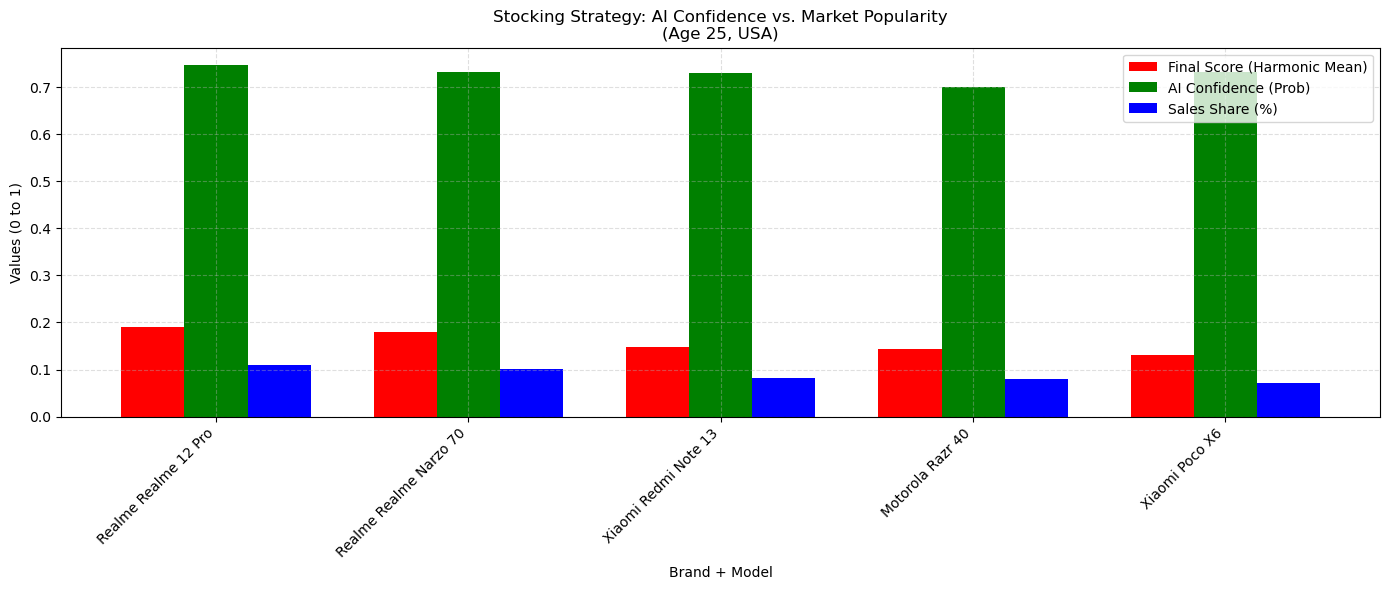

In [157]:
plot_recommendations_full(age=25, country="USA", max_price=70000, top_k=5)

In [158]:
def plot_price_vs_sentiment(age, country, max_price, top_k=15):
    rec = recommend_stock_age_smooth_with_sales(age, country, max_price, top_k)

    if isinstance(rec, str):
        print(rec)
        return

    # Combine brand + model for labeling
    rec['full_model'] = rec['brand'] + " " + rec['model']

    plt.figure(figsize=(10,5))
    plt.scatter(rec['price_inr'], rec['final_score'], s=120, color='green')
    plt.xlabel("Price (INR)")
    plt.ylabel("Final Score (ML Probability + Sales %)")
    plt.title(f"Price vs Final Score\n(Age Window: {age-3} to {age+3}, Country: {country})")
    plt.grid(True, linestyle='--', alpha=0.5)

    # Label each point with its model name
    for i in range(len(rec)):
        plt.text(
            rec['price_inr'].iloc[i],
            rec['final_score'].iloc[i],
            rec['full_model'].iloc[i],
            fontsize=8,
            ha='left'
        )

    plt.tight_layout()
    plt.show()

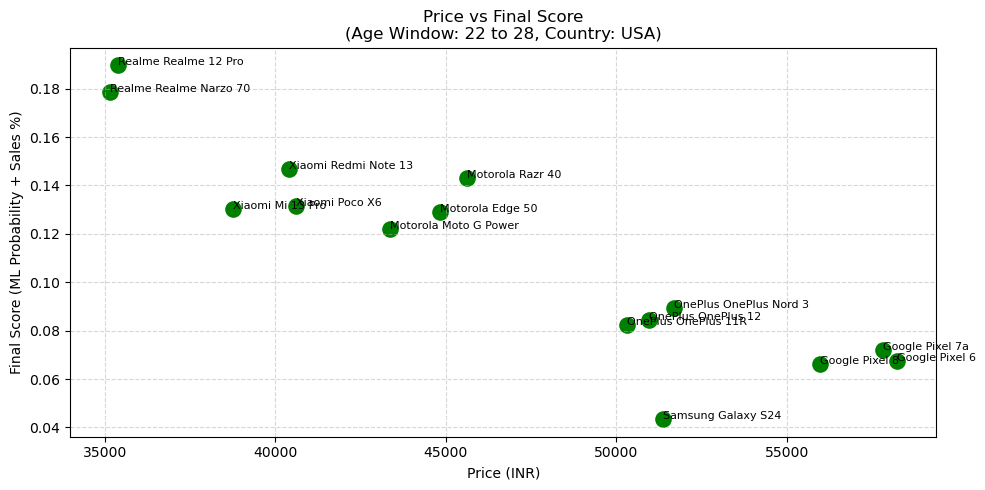

In [159]:
plot_price_vs_sentiment(age=25, country="USA", max_price=70000)

# Age and Country has no relation over Sentiments


In [161]:
# Create a temporary dataframe for correlation analysis
# We don't want to change the main 'df' because the AI Pipeline needs the text names
df_analysis = df[['age', 'sentiment', 'country']].copy()

# Convert 'country' to numbers ONLY for this correlation check
df_analysis['country'] = df_analysis['country'].astype('category').cat.codes

# Now run correlation
print(df_analysis.corr())

                age  sentiment   country
age        1.000000  -0.001934  0.005639
sentiment -0.001934   1.000000  0.001274
country    0.005639   0.001274  1.000000


In [124]:
df.groupby('country')['sentiment'].mean()

country
0    0.736941
1    0.735255
2    0.729384
3    0.730523
4    0.729811
5    0.748529
6    0.734949
7    0.732097
Name: sentiment, dtype: float64

In [125]:
pd.crosstab(df['country'], df['sentiment'])

sentiment,0.0,1.0
country,,
0,982,2751
1,992,2755
2,1014,2733
3,1010,2738
4,987,2666
5,940,2798
6,995,2759
7,1040,2842


In [126]:
from scipy.stats import chi2_contingency
chi2_contingency(pd.crosstab(df['country'], df['sentiment']))

Chi2ContingencyResult(statistic=np.float64(5.2321377897339065), pvalue=np.float64(0.631657630930954), dof=7, expected_freq=array([[ 990.42330511, 2742.57669489],
       [ 994.13772415, 2752.86227585],
       [ 994.13772415, 2752.86227585],
       [ 994.4030398 , 2753.5969602 ],
       [ 969.19805346, 2683.80194654],
       [ 991.74988334, 2746.25011666],
       [ 995.99493367, 2758.00506633],
       [1029.95533631, 2852.04466369]]))

In [127]:
def predict_sentiment(age, brand, model_name, price_inr, rating, country):
    
    # Check if input brand/model/country exist in training classes
    if brand not in le_brand.classes_:
        return f"Brand '{brand}' not found in training data."
    if model_name not in le_model.classes_:
        return f"Model '{model_name}' not found in training data."
    if country not in le_country.classes_:
        return f"Country '{country}' not found in training data."
    
    # Build the input row exactly as pipeline expects
    input_row = pd.DataFrame({
        'age': [age],
        'brand': [brand],            # RAW STRING
        'model': [model_name],       # RAW STRING
        'price_inr': [price_inr],
        'rating': [rating],
        'country': [country]         # RAW STRING
    })

    # Predict probability from logistic regression
    prob = pipe.predict_proba(input_row)[0][1]
    
    sentiment_class = 1 if prob >= 0.5 else 0
    label = "Positive" if sentiment_class == 1 else "Negative"
    
    return {
        'predicted_probability': prob,
        'predicted_sentiment': label
    }

In [128]:
predict_sentiment(age=18, brand="Apple", model_name="iPhone SE", price_inr=40000, rating=4, country="India")


{'predicted_probability': np.float64(0.999348958113232),
 'predicted_sentiment': 'Positive'}

In [129]:
predict_sentiment(age=60, brand="Apple", model_name="iPhone SE", price_inr=40000, rating=4, country="India")

{'predicted_probability': np.float64(0.9992064837999061),
 'predicted_sentiment': 'Positive'}

In [130]:
predict_sentiment(age=18, brand="Motorola", model_name="Edge 50", price_inr=20000, rating=2, country="India")

{'predicted_probability': np.float64(0.6068291822185188),
 'predicted_sentiment': 'Positive'}

In [131]:
predict_sentiment(age=18, brand="Motorola", model_name="Edge 50", price_inr=20000, rating=5, country="India")

{'predicted_probability': np.float64(0.9999786159782798),
 'predicted_sentiment': 'Positive'}

In [162]:
def plot_final_score_vs_sales(age, country, max_price, top_k=10):
    rec = recommend_stock_age_smooth_with_sales(age, country, max_price, top_k)

    if isinstance(rec, str):
        print(rec)
        return

    rec['full_model'] = rec['brand'] + " " + rec['model']

    plt.figure(figsize=(10,5))
    plt.scatter(rec['sales_percent'], rec['final_score'], s=120, color='red')
    plt.xlabel("Sales Percentage")
    plt.ylabel("Final Score")
    plt.title(f"Final Score vs Sales %\n(Age Window {age-3}–{age+3}, Country={country})")
    plt.grid(True, linestyle='--', alpha=0.5)

    for i in range(len(rec)):
        plt.text(
            rec['sales_percent'].iloc[i],
            rec['final_score'].iloc[i],
            rec['full_model'].iloc[i],
            fontsize=8
        )

    plt.tight_layout()
    plt.show()

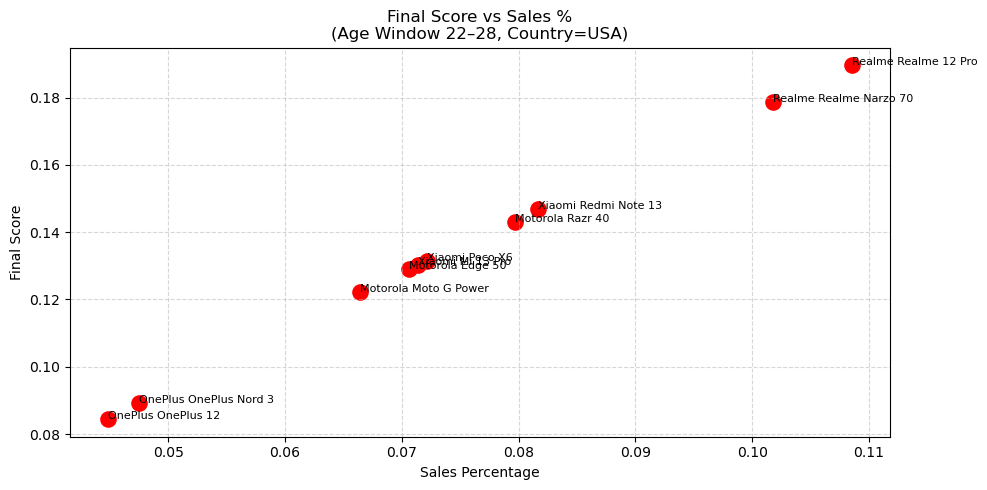

In [163]:
plot_final_score_vs_sales(age=25, country="USA", max_price=70000)

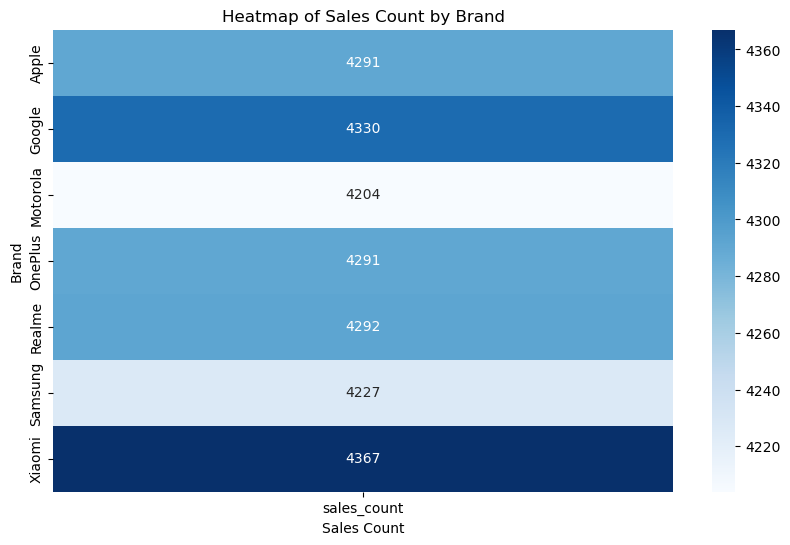

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count number of sales (verified reviews) per brand
brand_sales = df_raw.groupby('brand').size().reset_index(name='sales_count')

# Pivot not needed since it's single column, but seaborn heatmap requires 2D
brand_sales_pivot = brand_sales.pivot_table(
    index='brand',
    values='sales_count'
)

plt.figure(figsize=(10,6))
sns.heatmap(brand_sales_pivot, annot=True, fmt=".0f", cmap="Blues")
plt.title("Heatmap of Sales Count by Brand")
plt.xlabel("Sales Count")
plt.ylabel("Brand")
plt.show()

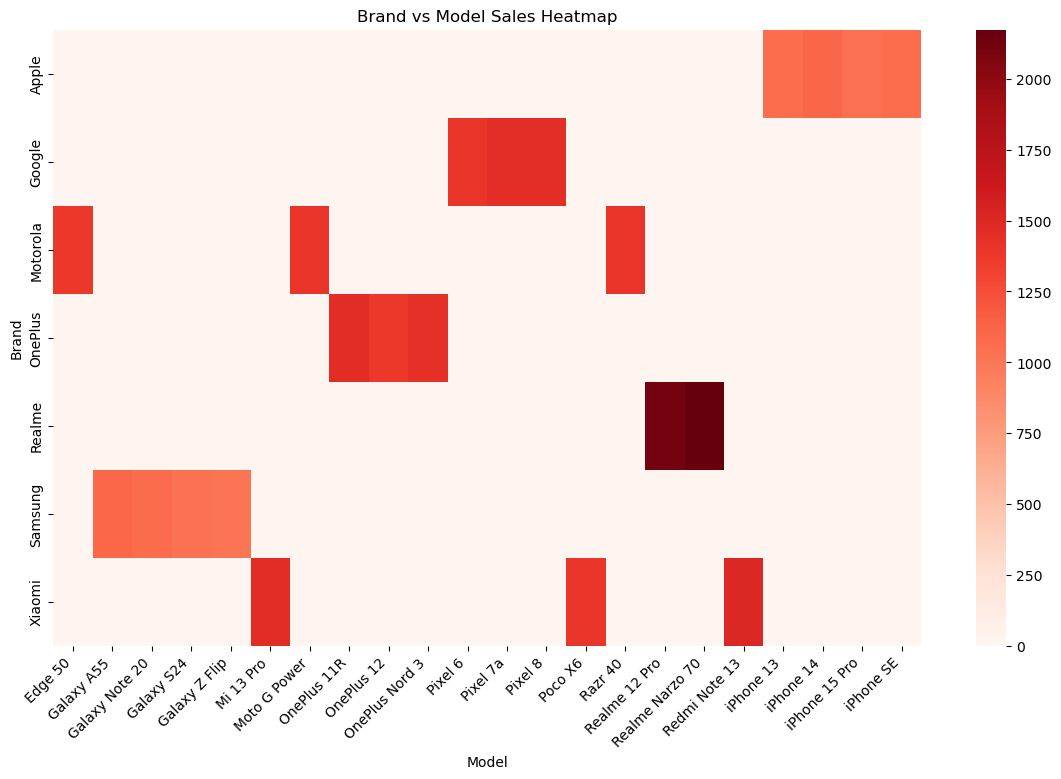

In [165]:
brand_model_sales = df_raw.groupby(['brand','model']).size().reset_index(name='sales_count')

pivot = brand_model_sales.pivot(
    index='brand',
    columns='model',
    values='sales_count'
).fillna(0)

plt.figure(figsize=(14,8))
sns.heatmap(pivot, annot=False, cmap="Reds")
plt.title("Brand vs Model Sales Heatmap")
plt.xlabel("Model")
plt.ylabel("Brand")
plt.xticks(rotation=45, ha='right')
plt.show()

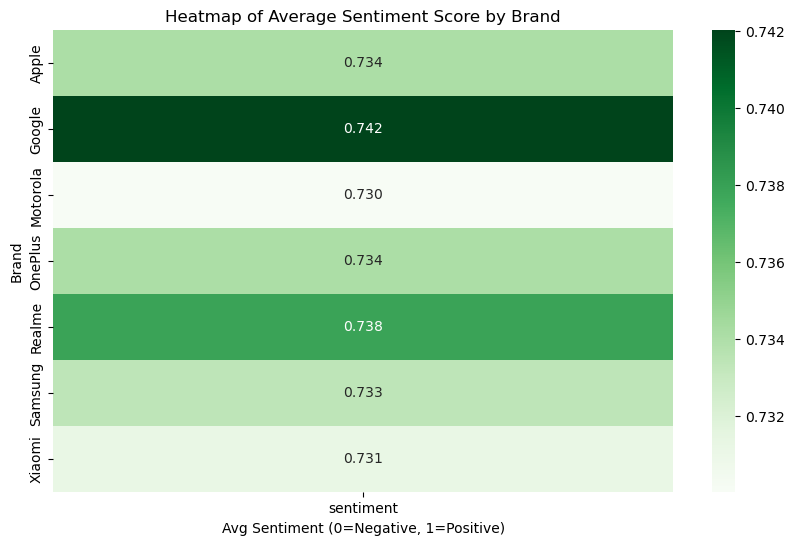

In [166]:
brand_sentiment = df_raw.groupby('brand')['sentiment'].mean().reset_index()
brand_sentiment_pivot = brand_sentiment.pivot_table(
    index='brand',
    values='sentiment'
)

plt.figure(figsize=(10,6))
sns.heatmap(brand_sentiment_pivot, annot=True, fmt=".3f", cmap="Greens")
plt.title("Heatmap of Average Sentiment Score by Brand")
plt.xlabel("Avg Sentiment (0=Negative, 1=Positive)")
plt.ylabel("Brand")
plt.show()